In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import glob
import itertools

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from tqdm import tqdm
import xgboost as xgb #BDT
import pickle
import yahist
import mplhep as hep

import concurrent.futures as futures

from utils.analysis import Validation, PandasAnalysis

TAG = "nopnetfix"

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = sorted(glob.glob(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/*.root"))
sig_babies = [baby for baby in babies if "VBS" in baby]
bkg_babies = [baby for baby in babies if "VBS" not in baby and "data" not in baby]
data_babies = [baby for baby in babies if "data" in baby]
print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/OSVBSWWH.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/SSVBSWWH.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/VBSVVH.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/VBSWZH.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/VBSZZH.root
Background:
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/Bosons.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/QCD.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/SingleTop.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/TT1L.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/TTH.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/TTHad.root
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/TTW.root
Data:
../analysis/studies/vbsvvhjets/output_nopnetfix/Run2/data.root


In [3]:
plots_dir = f"/home/users/jguiang/public_html/vbsvvhjets_plots/{TAG}/val"
vbsvvh = Validation(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf",
        "prefire_sf",
    ],
    plots_dir=plots_dir,
    sample_labels = {
        "VBSVVH": r"VBS VVH $(C_{2V} = 2)$", 
        "TTHad": r"$t\bar{t}+$jets",
        "TT1L": r"$t\bar{t}+1\ell$",
        "QCD": "QCD",
        "SingleTop": r"Single $t$",
        "TTH": r"$t\bar{t}+H$",
        "TTW": r"$t\bar{t}+W$",
    },
)

vbsvvh.df["objsel"] = True
vbsvvh.df["presel"] = vbsvvh.df.eval(
    "objsel and hbbfatjet_xbb > 0.5 and ld_vqqfatjet_xwqq > 0.3 and tr_vqqfatjet_xwqq > 0.3"
)

# with open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_features.txt", "r") as txt_file:
#     features = txt_file.read().splitlines()
# bst = pickle.load(open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.pkl", "rb"))
# vbsvvh.df["bdt"] = bst.predict(xgb.DMatrix(vbsvvh.df[features]))

# bkg_count = vbsvvh.bkg_count()
# qcd_count = vbsvvh.sample_count("QCD")
# data_count = vbsvvh.data_count()

# vbsvvh.df.loc[vbsvvh.df.name == "QCD", "event_weight"] *= (data_count - (bkg_count - qcd_count))/(qcd_count)

Loading data babies: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


In [4]:
# New cuts: "bdt > 0.75 and hbbfatjet_score > 0.9 and ld_vqqfatjet_score > 0.80 and tr_vqqfatjet_score > 0.65"

vbsvvh.df["dphi_VV"] = np.arccos(np.cos(vbsvvh.df.ld_vqqfatjet_phi - vbsvvh.df.tr_vqqfatjet_phi))
vbsvvh.df["dphi_ldVH"] = np.arccos(np.cos(vbsvvh.df.hbbfatjet_phi - vbsvvh.df.ld_vqqfatjet_phi))
vbsvvh.df["dphi_trVH"] = np.arccos(np.cos(vbsvvh.df.hbbfatjet_phi - vbsvvh.df.tr_vqqfatjet_phi))
vbsvvh.df["dphi_jj"] = np.arccos(np.cos(vbsvvh.df.ld_vbsjet_phi - vbsvvh.df.tr_vbsjet_phi))

In [5]:
history = {}

def plot_many(plot_tuples, sel="obj_sel", norm=False, sig_scale=0, year=None, ratio_ylim=[0, 2]):
    if year:
        sel = f"{sel} and abs(year) == {year}"
    for var, bins, label in plot_tuples:
        if year:
            if year == 2016:
                vbsvvh.lumi = 36.33
            elif year == 2017:
                vbsvvh.lumi = 41.48
            elif year == 2018:
                vbsvvh.lumi = 59.83
        
        plot_hash = hash((var, sel, norm, year))
        plot_subhash = hash((",".join(bins.astype(str)), sig_scale, label))
        if history.get(plot_hash, None) != plot_subhash:
            vbsvvh.plot_data_vs_mc(
                var, bins, selection=sel, norm=norm, x_label=label, sig_scale=sig_scale, stacked=True
            )
            history[plot_hash] = plot_subhash
        else:
            print("This plot has already been plotted during the runtime of this kernel")
            
        if year:
            vbsvvh.lumi = 138

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/hbbfatjet_xbb_data_vs_mc_norm_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/ld_vqqfatjet_xwqq_data_vs_mc_norm_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/tr_vqqfatjet_xwqq_data_vs_mc_norm_objsel.pdf


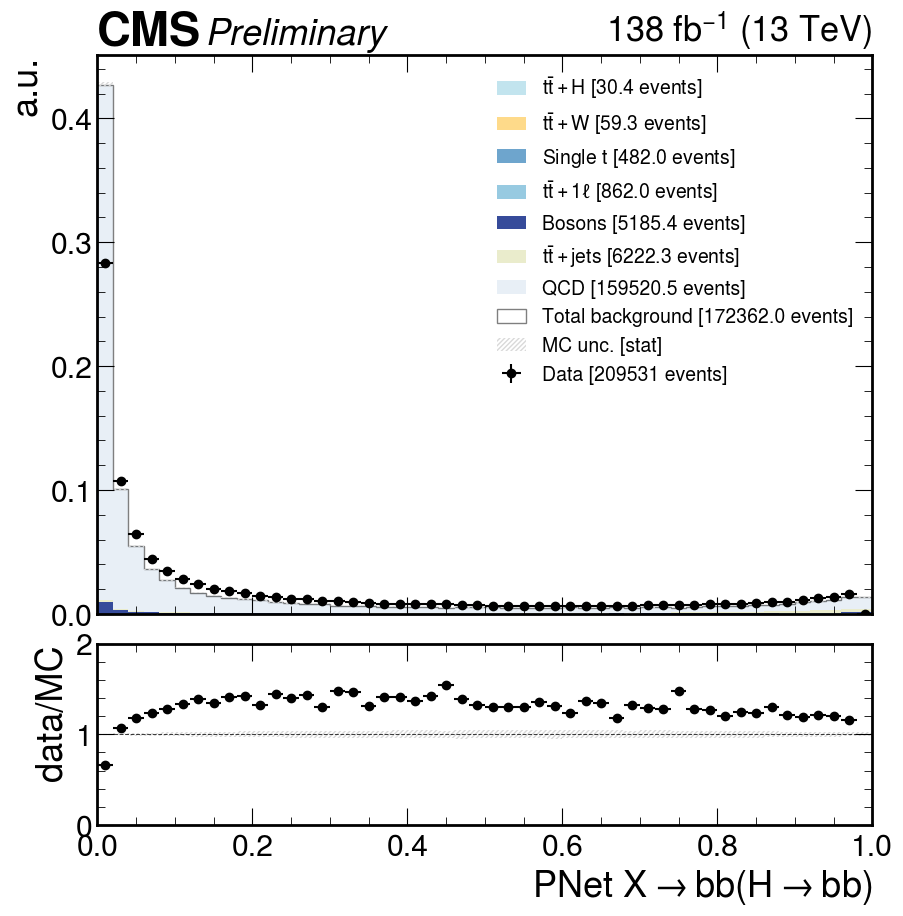

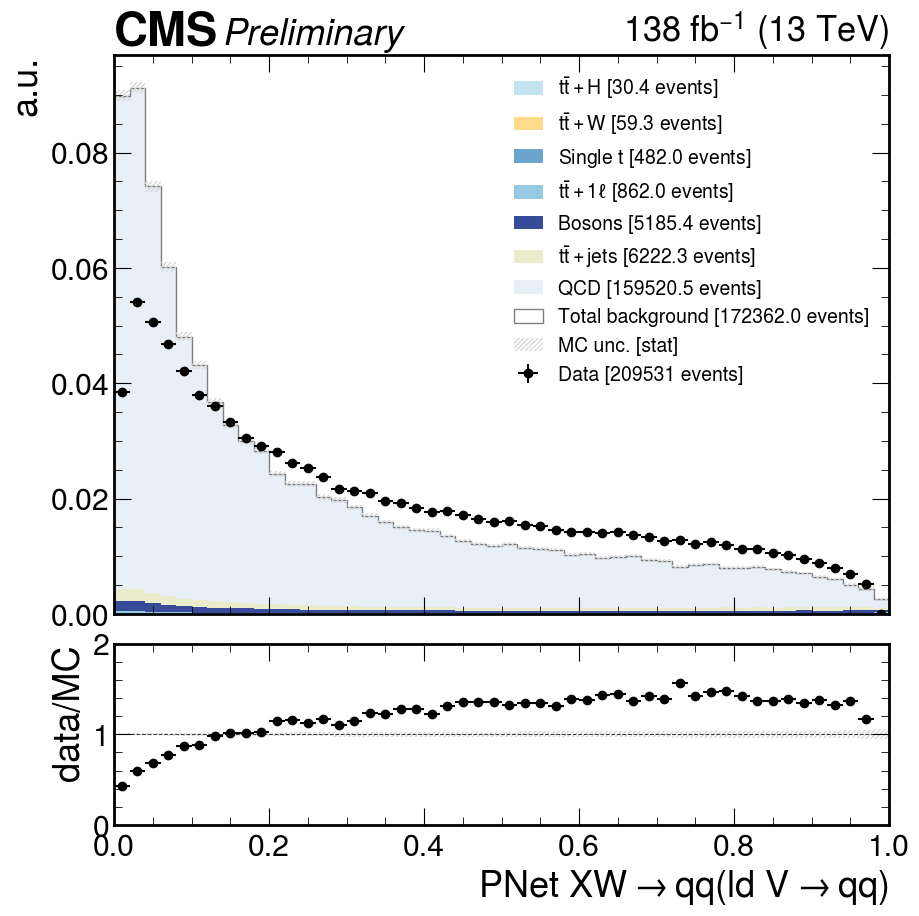

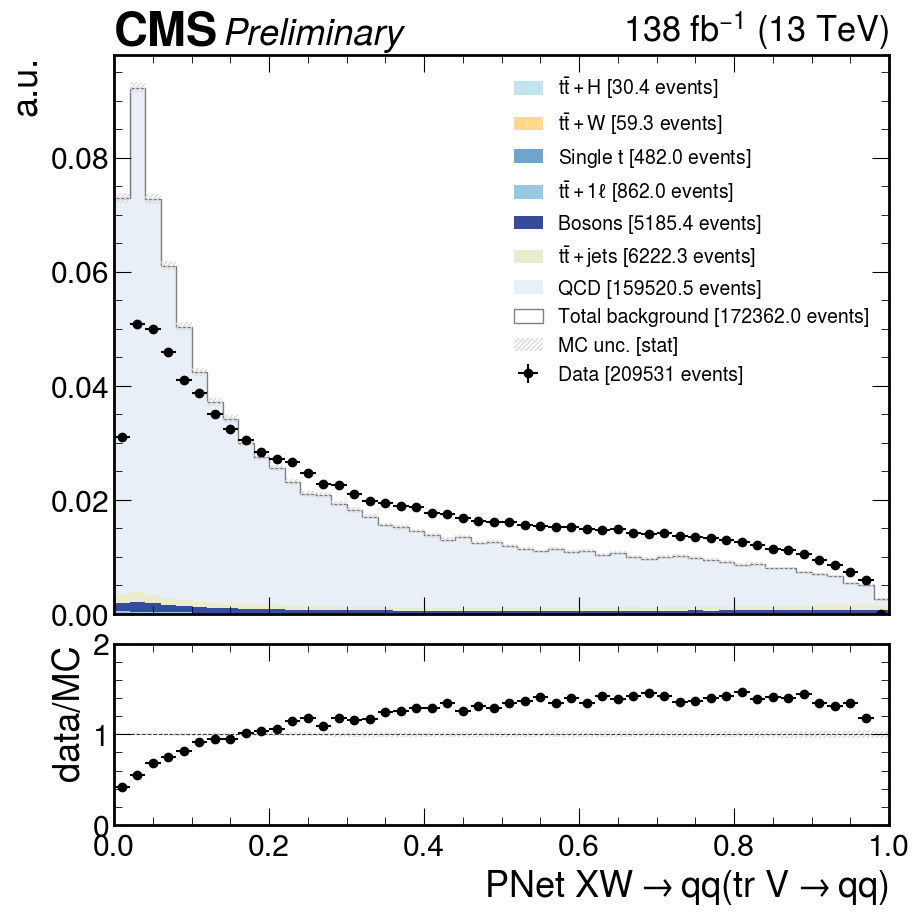

In [6]:
nbins = 50

plot_many(
    [
        # Fat jet ParticleNet score
        ("hbbfatjet_xbb", np.linspace(0, 1, nbins+1), r"PNet $X\rightarrow bb(H\rightarrow bb)$"),
        ("ld_vqqfatjet_xwqq", np.linspace(0, 1, nbins+1), r"PNet $XW\rightarrow qq($ld $V\rightarrow qq)$"),
        ("tr_vqqfatjet_xwqq", np.linspace(0, 1, nbins+1), r"PNet $XW\rightarrow qq($tr $V\rightarrow qq)$"),
    ],
    sel="objsel",
    norm=True,
#     sig_scale=1000
)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/hbbfatjet_xbb_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/ld_vqqfatjet_xwqq_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/tr_vqqfatjet_xwqq_data_vs_mc_norm_presel.pdf


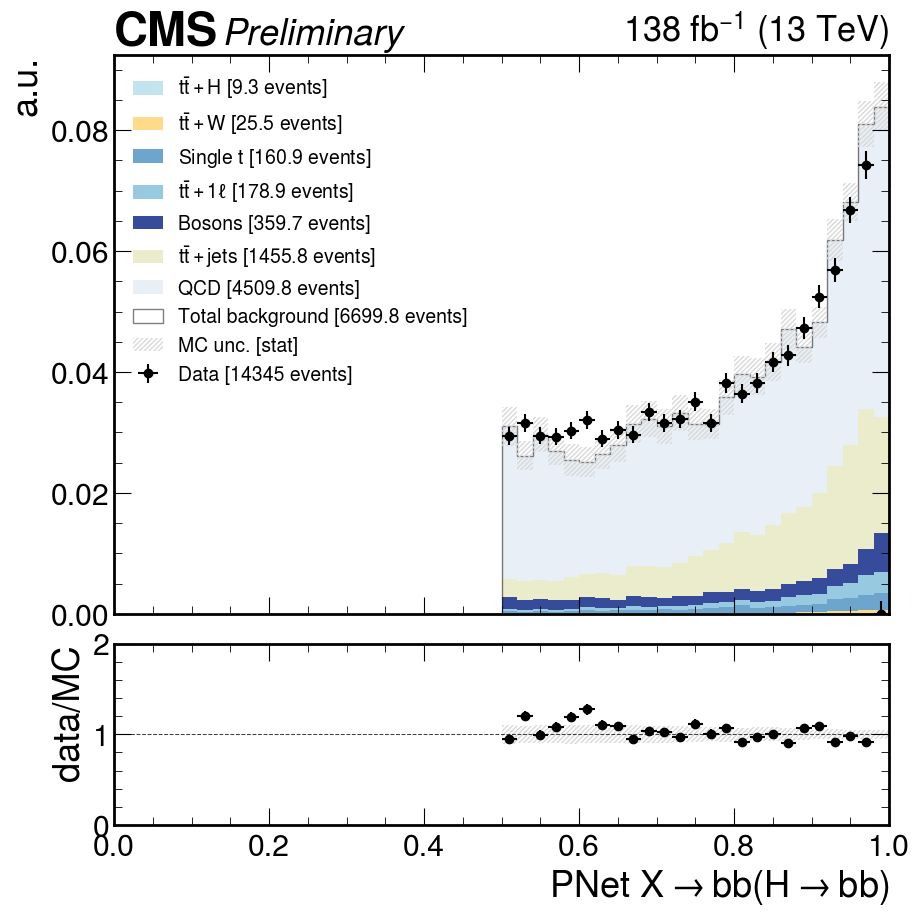

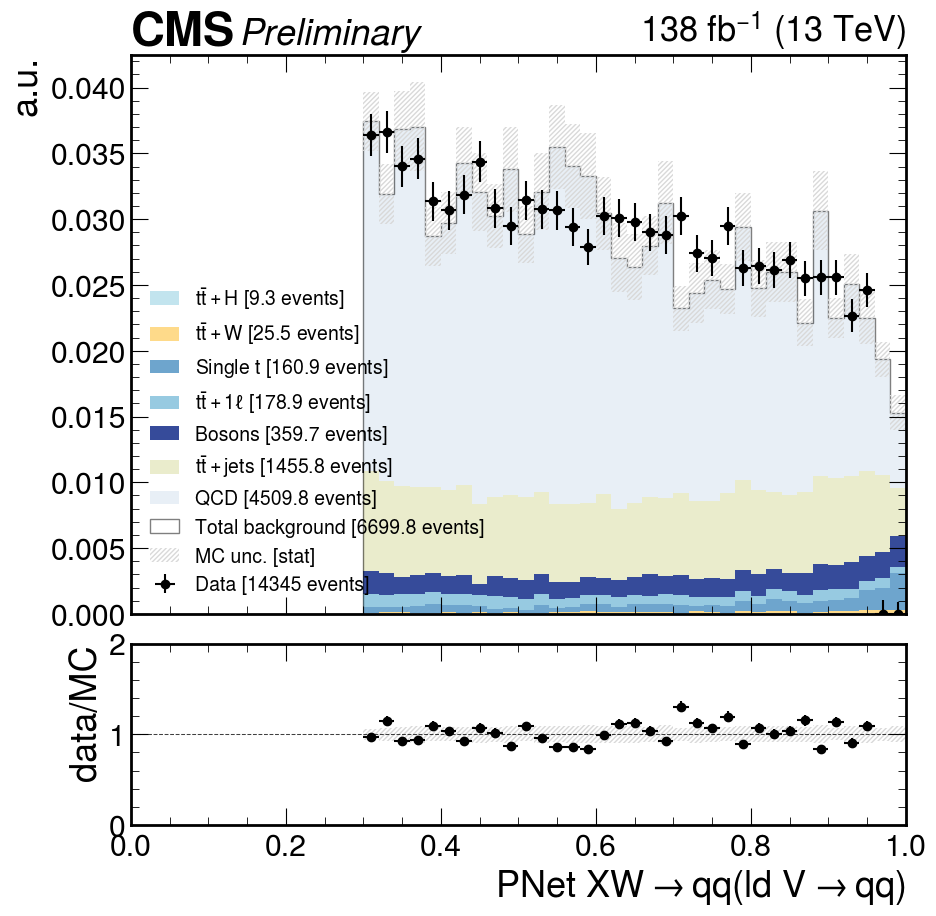

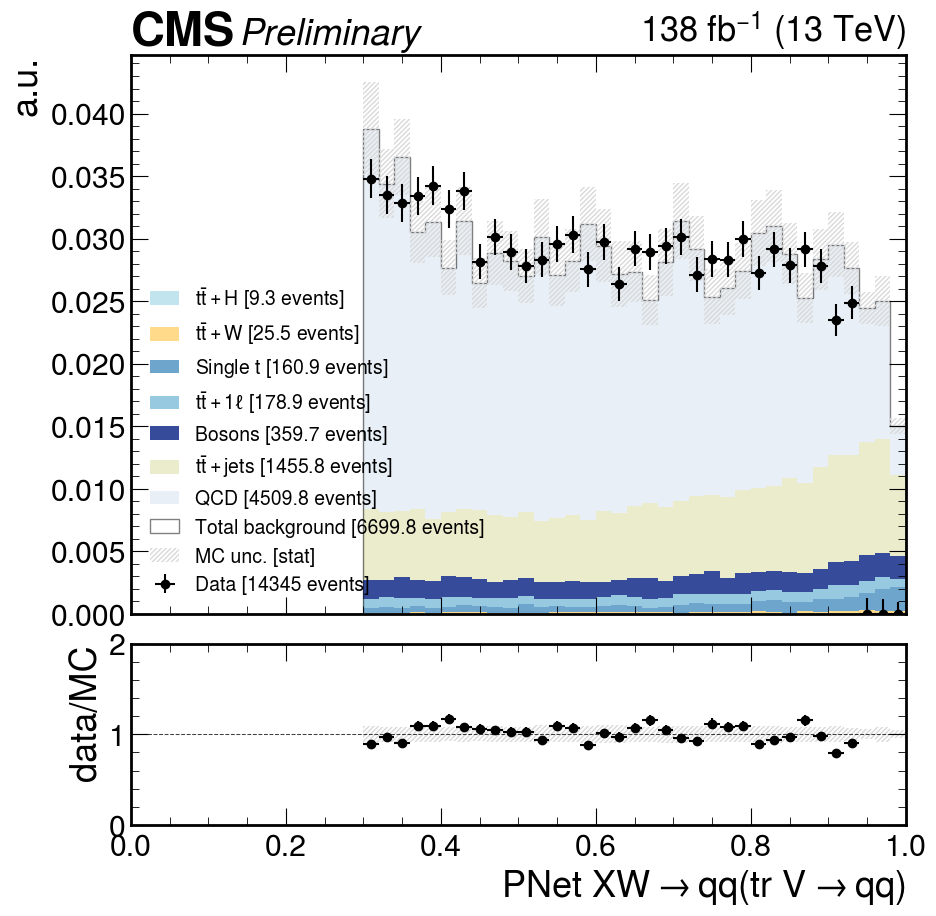

In [7]:
nbins = 50

plot_many(
    [
        # Fat jet ParticleNet score
        ("hbbfatjet_xbb", np.linspace(0, 1, nbins+1), r"PNet $X\rightarrow bb(H\rightarrow bb)$"),
        ("ld_vqqfatjet_xwqq", np.linspace(0, 1, nbins+1), r"PNet $XW\rightarrow qq($ld $V\rightarrow qq)$"),
        ("tr_vqqfatjet_xwqq", np.linspace(0, 1, nbins+1), r"PNet $XW\rightarrow qq($tr $V\rightarrow qq)$"),
    ],
    sel="presel",
    norm=True,
#     sig_scale=1000
)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/ST_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/HT_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/HT_fat_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/MET_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/n_jets_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/n_fatjets_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/M_jj_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/abs_deta_jj_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/ld_vbsjet_pt_data_vs_mc_norm_presel.pdf


/home/users/jguiang/projects/vbs/notebooks/utils/analysis.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/ld_vqqfatjet_mass_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/tr_vqqfatjet_mass_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/hbbfatjet_pt_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/ld_vqqfatjet_pt_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/tr_vqqfatjet_pt_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/hbbfatjet_eta_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/ld_vqqfatjet_eta_data_vs_mc_norm_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/nopnetfix/val/tr_vqqfatjet_eta_data_vs_mc_norm_presel.pdf


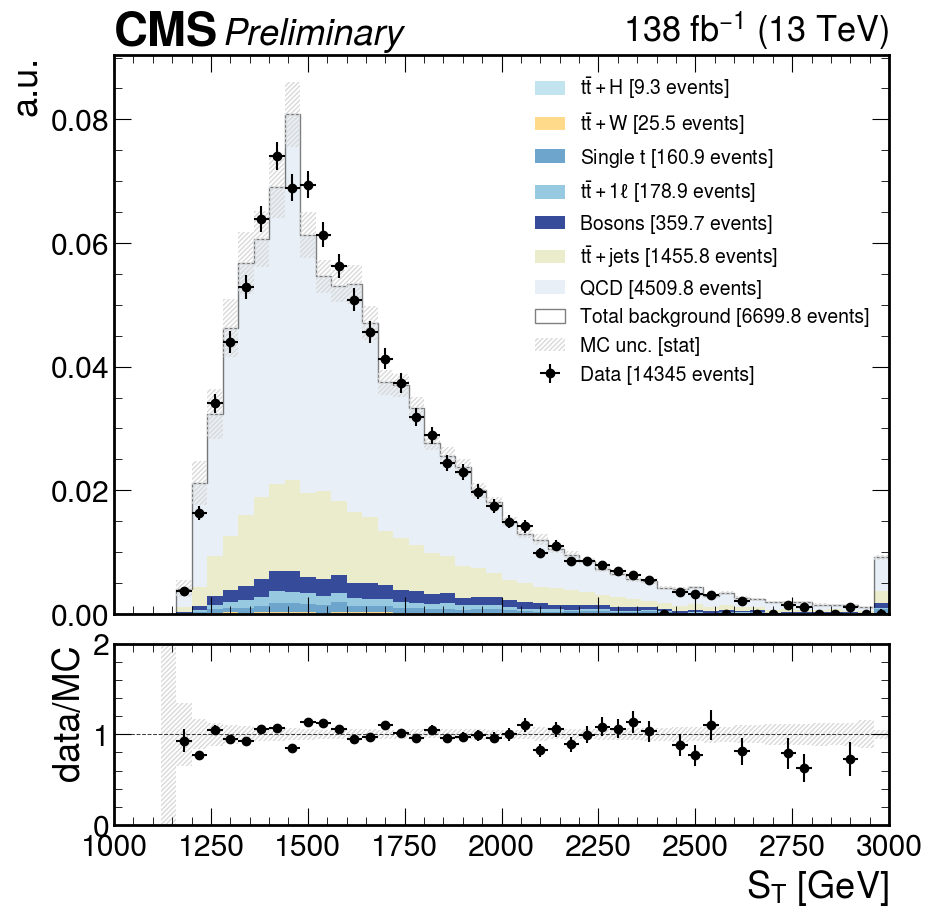

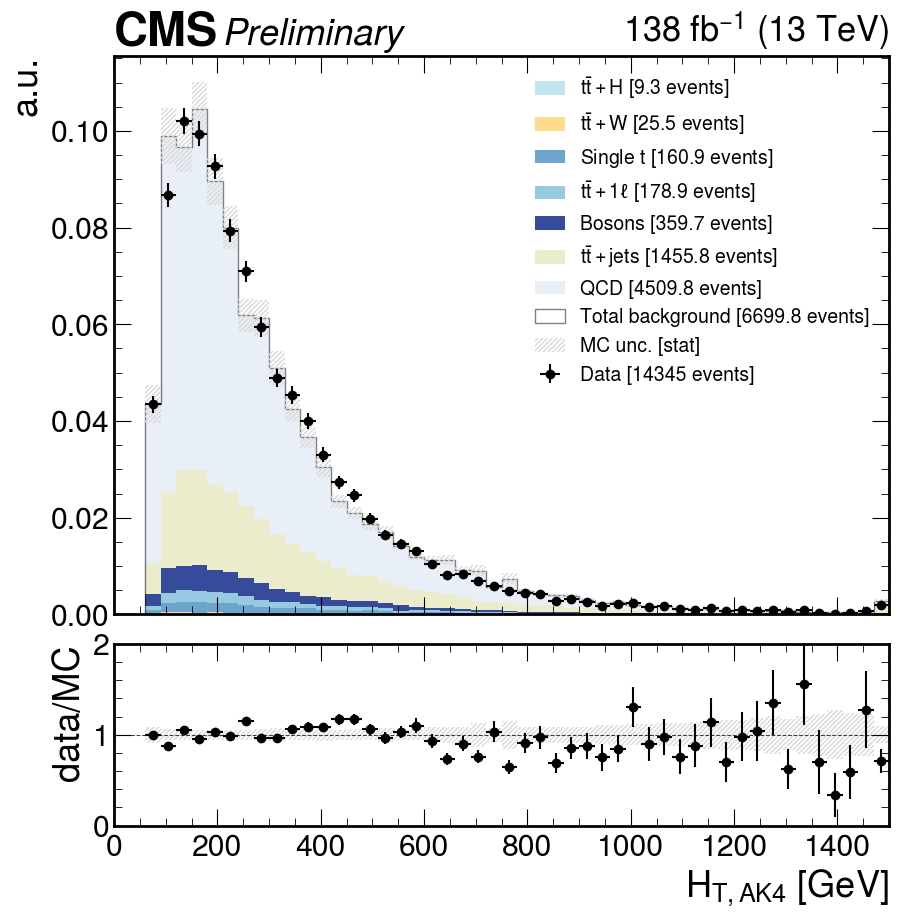

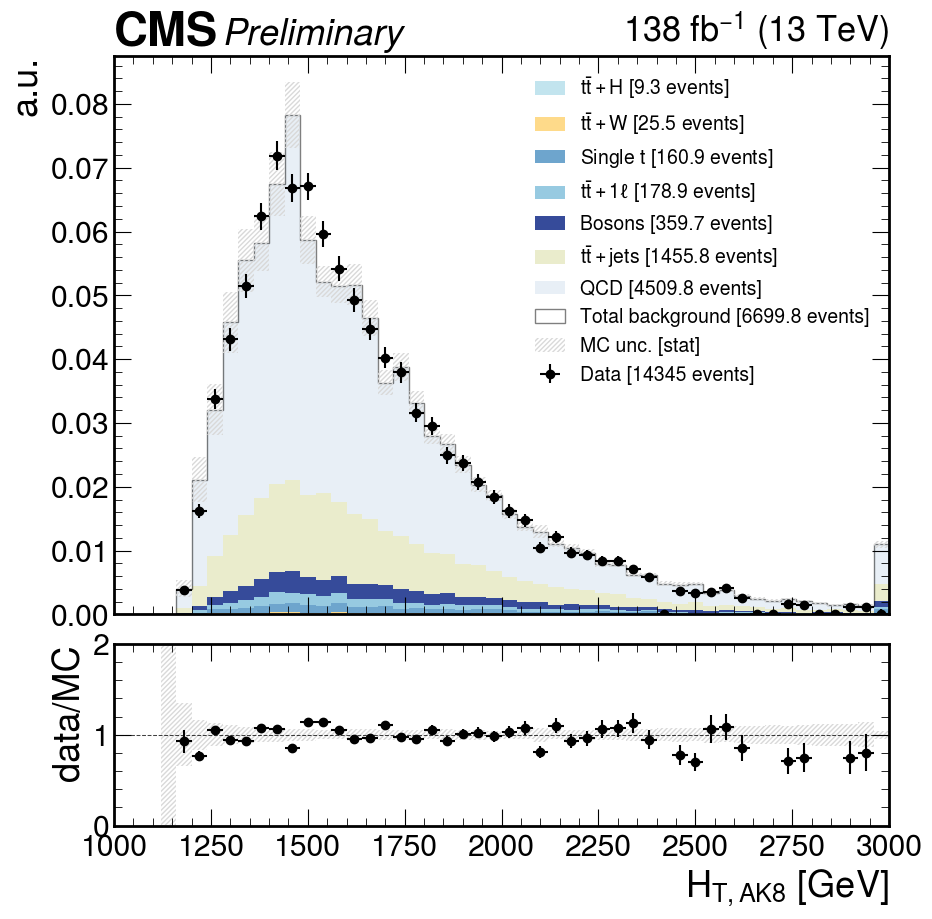

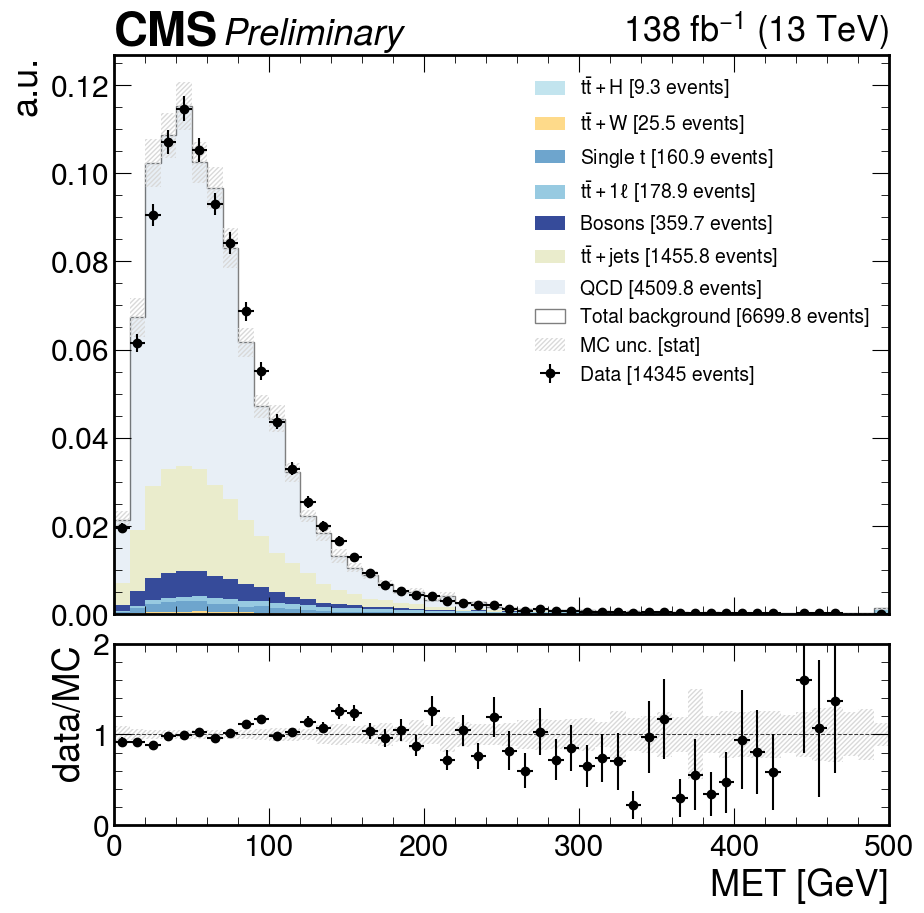

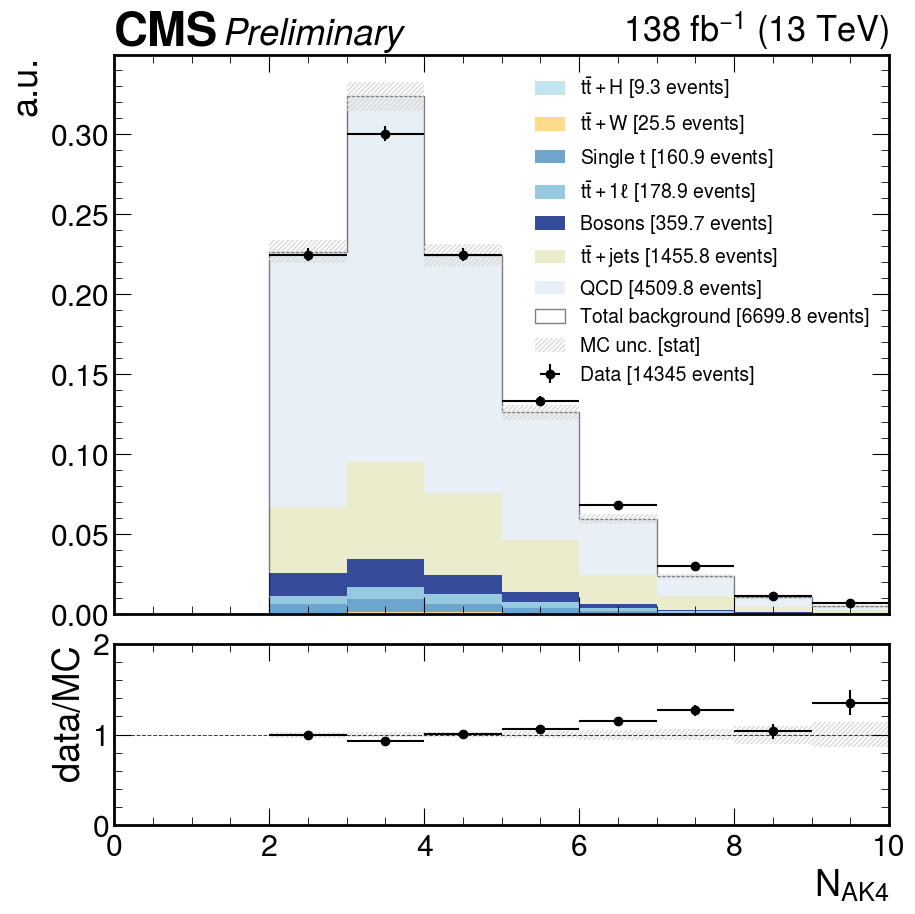

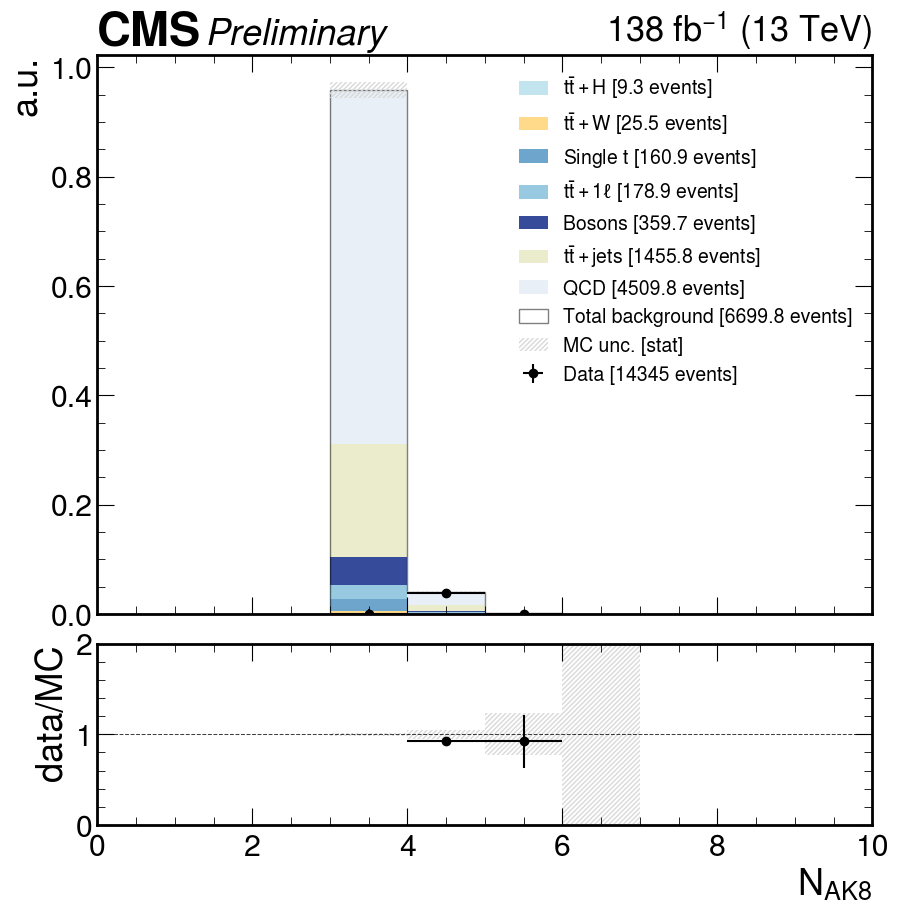

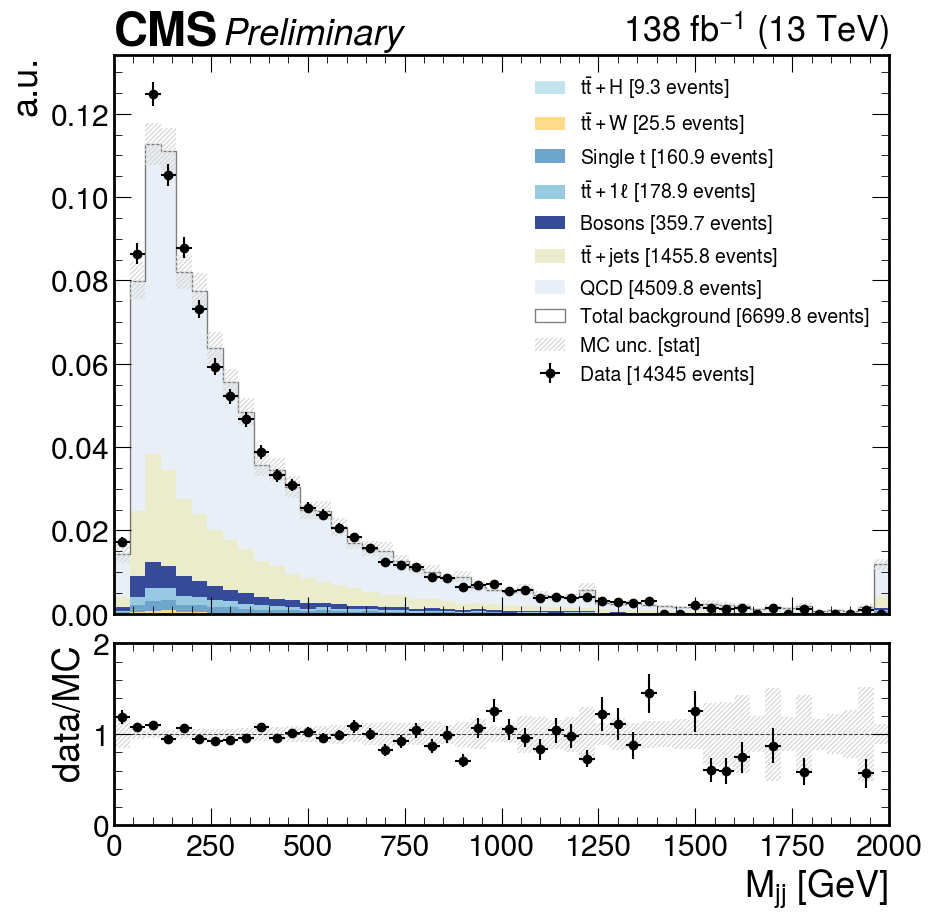

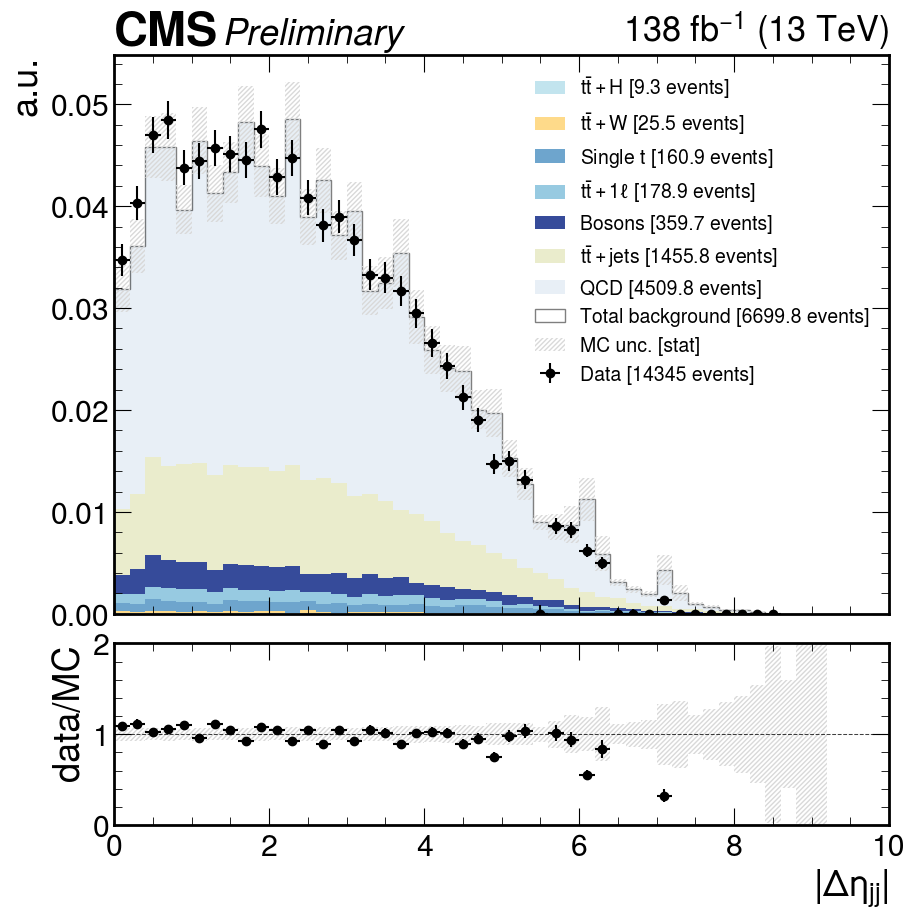

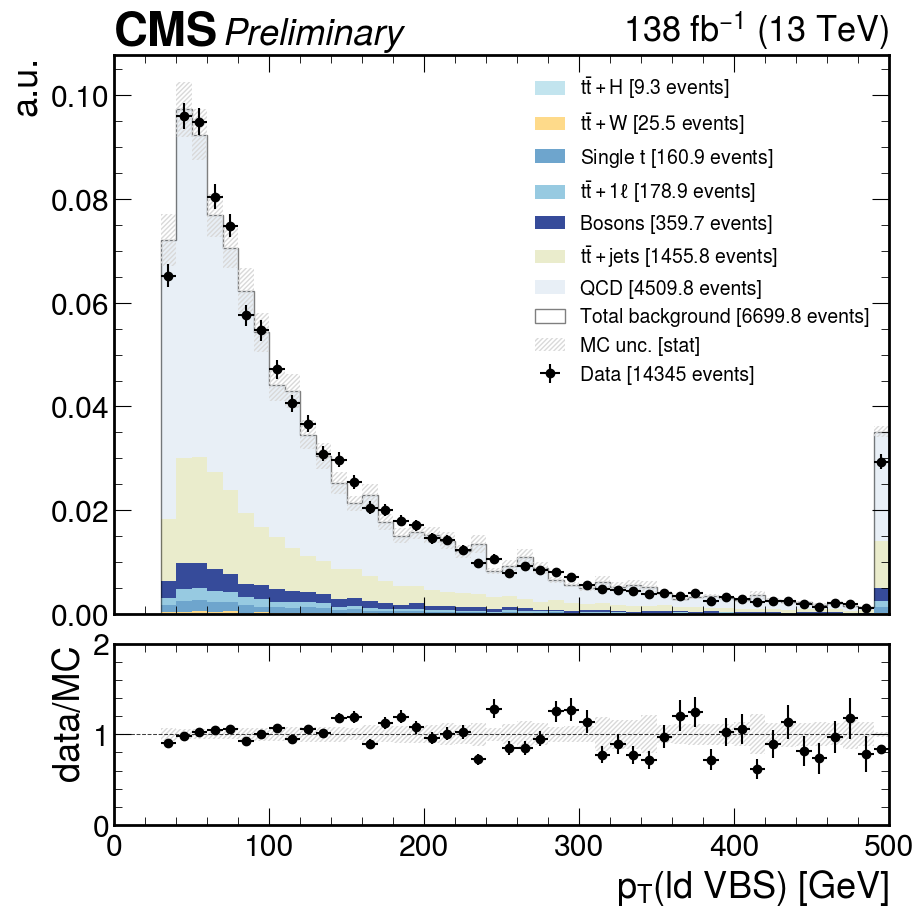

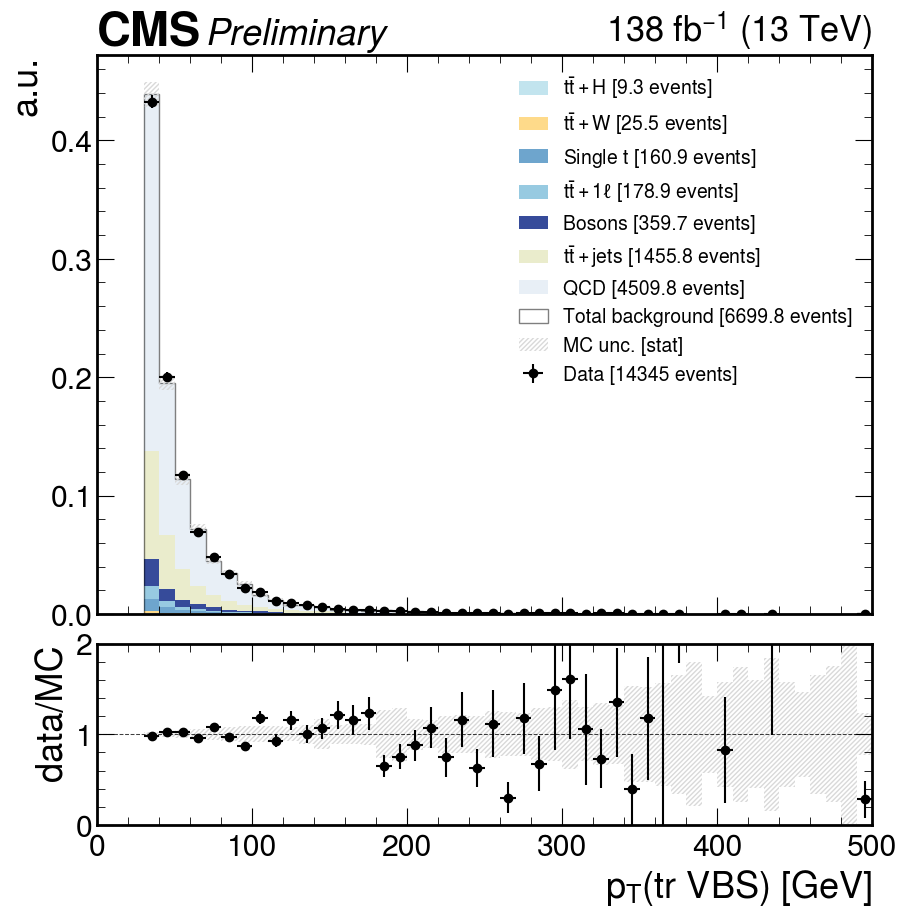

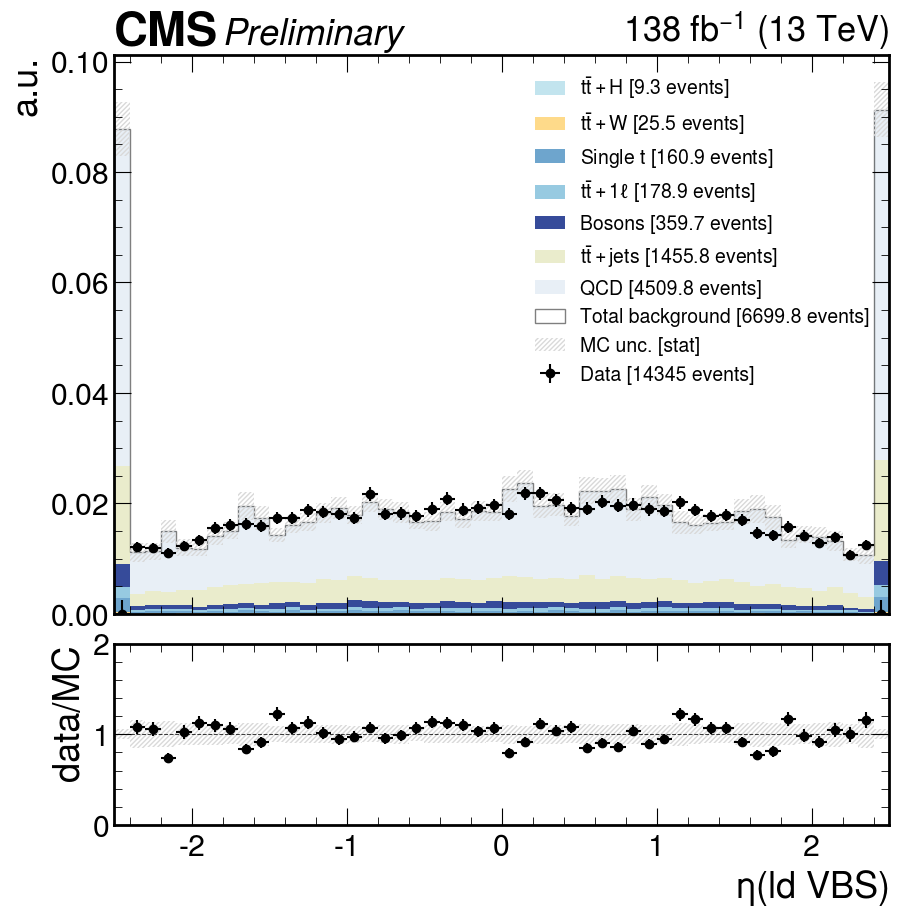

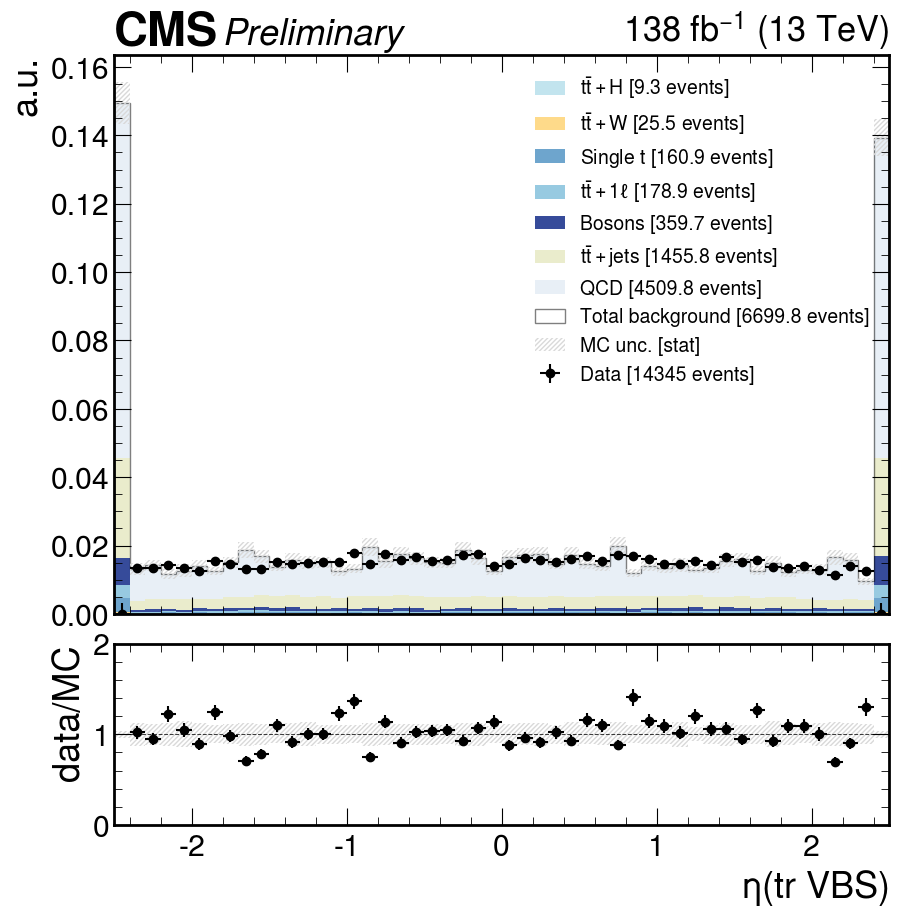

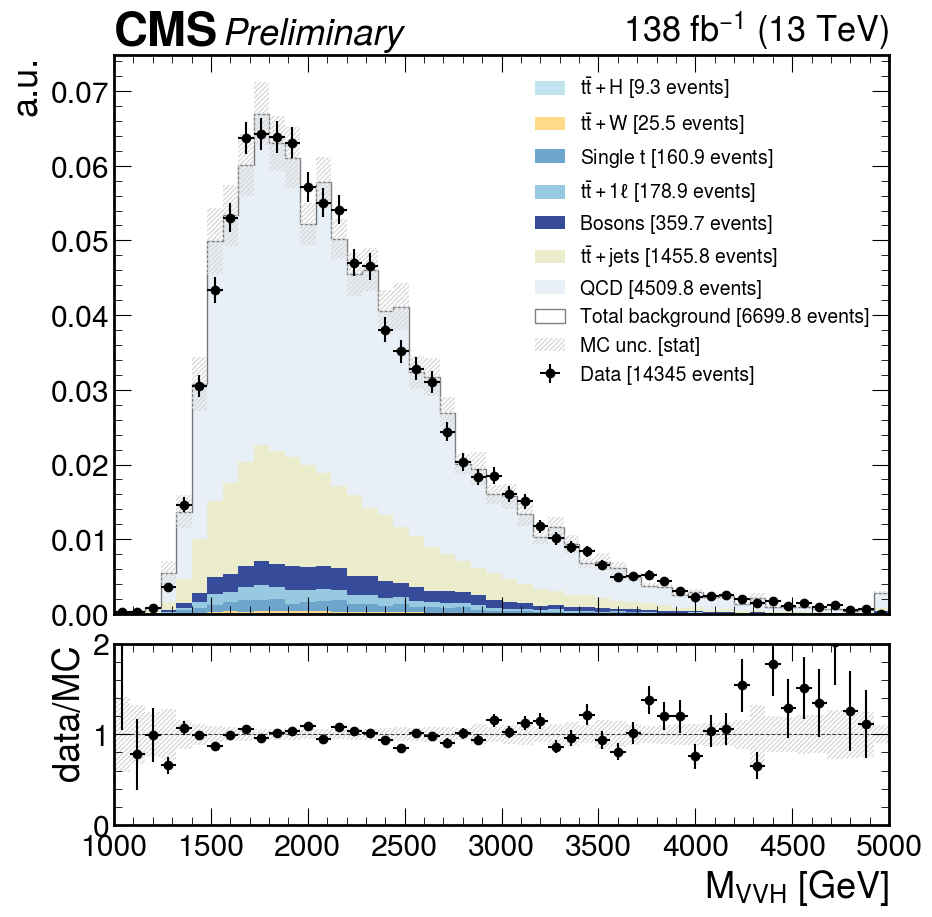

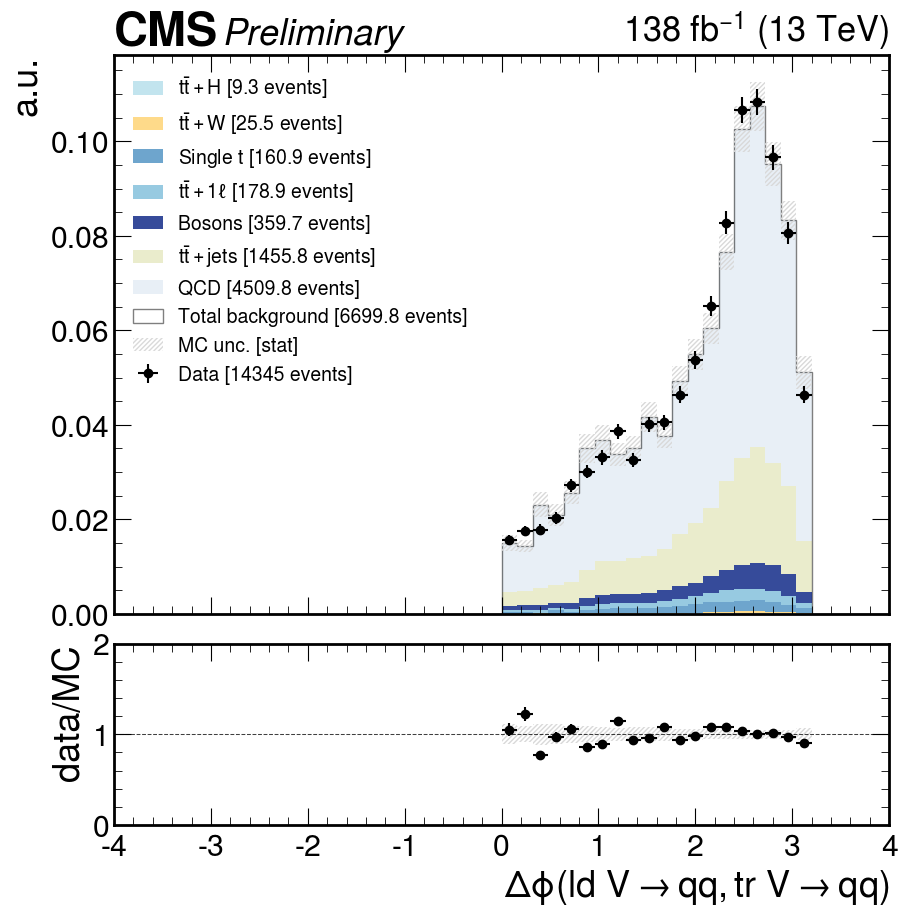

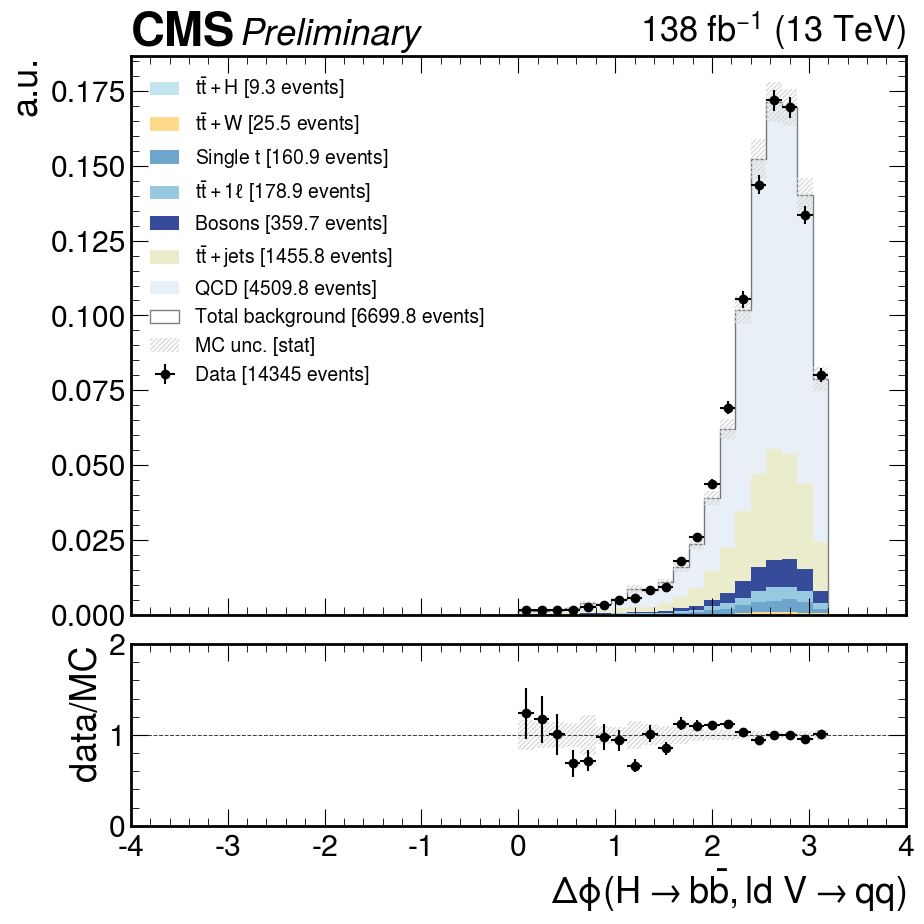

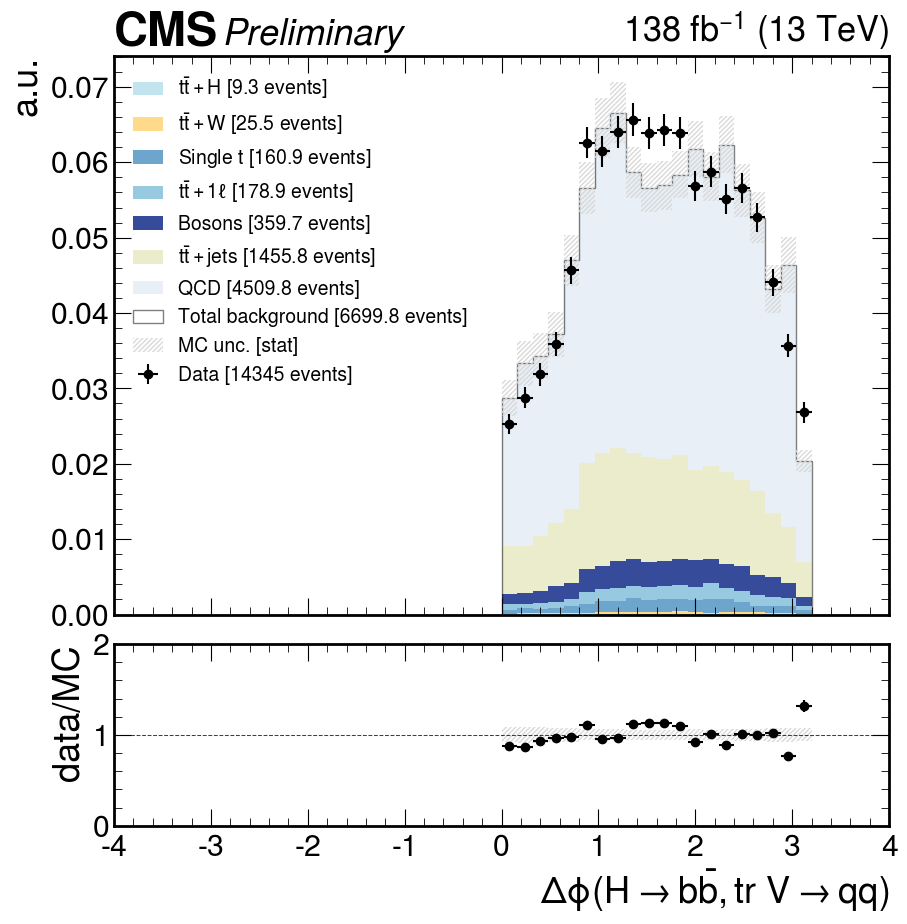

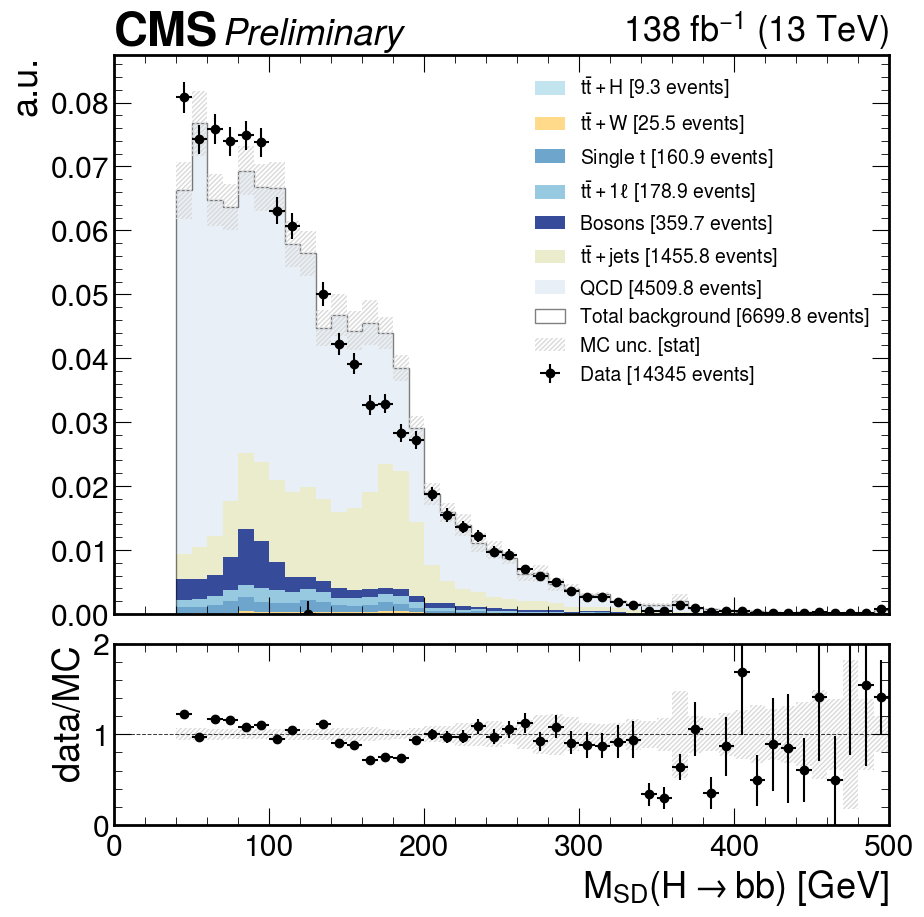

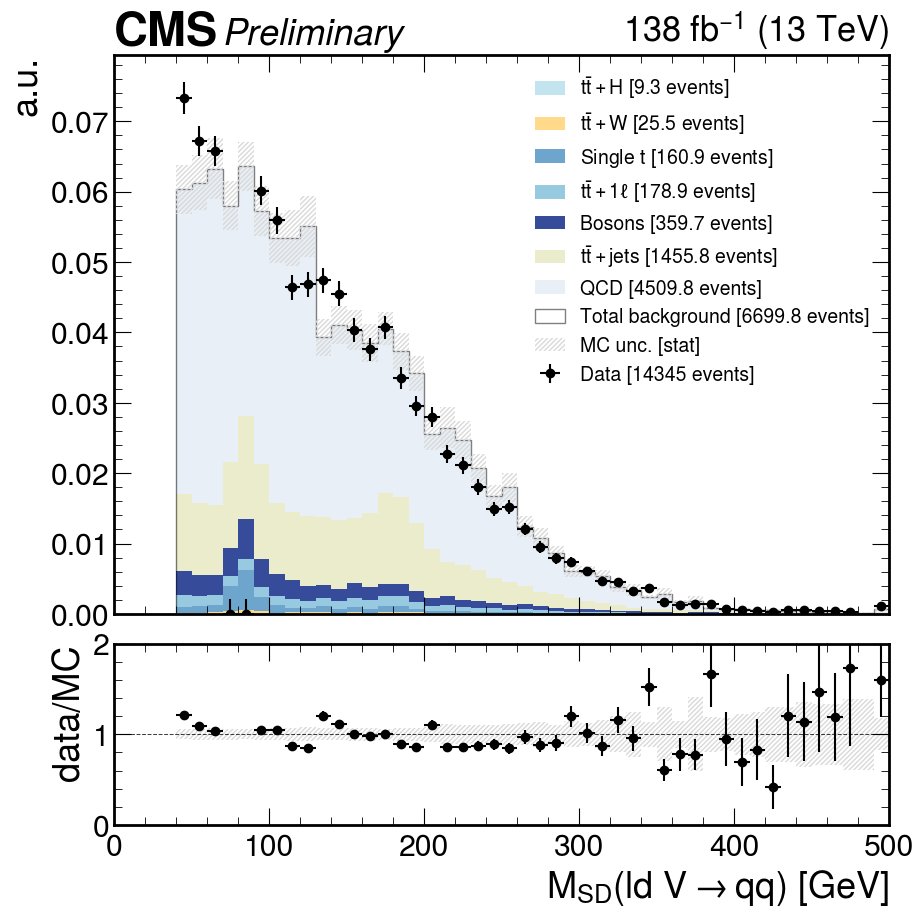

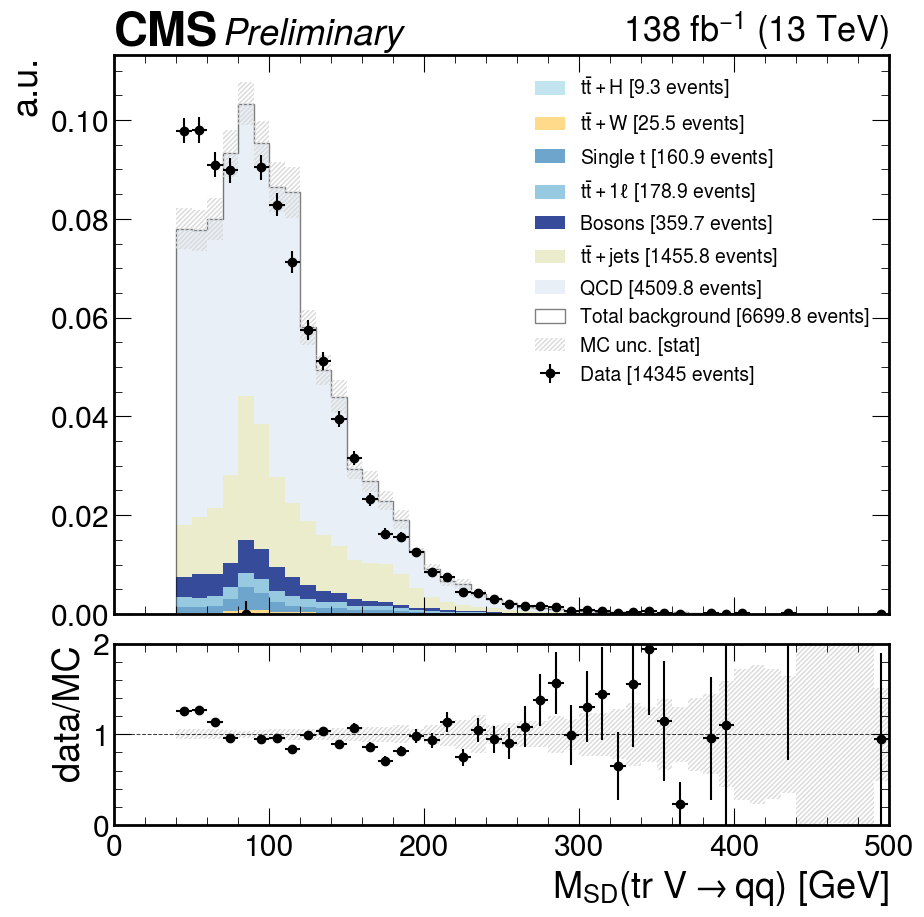

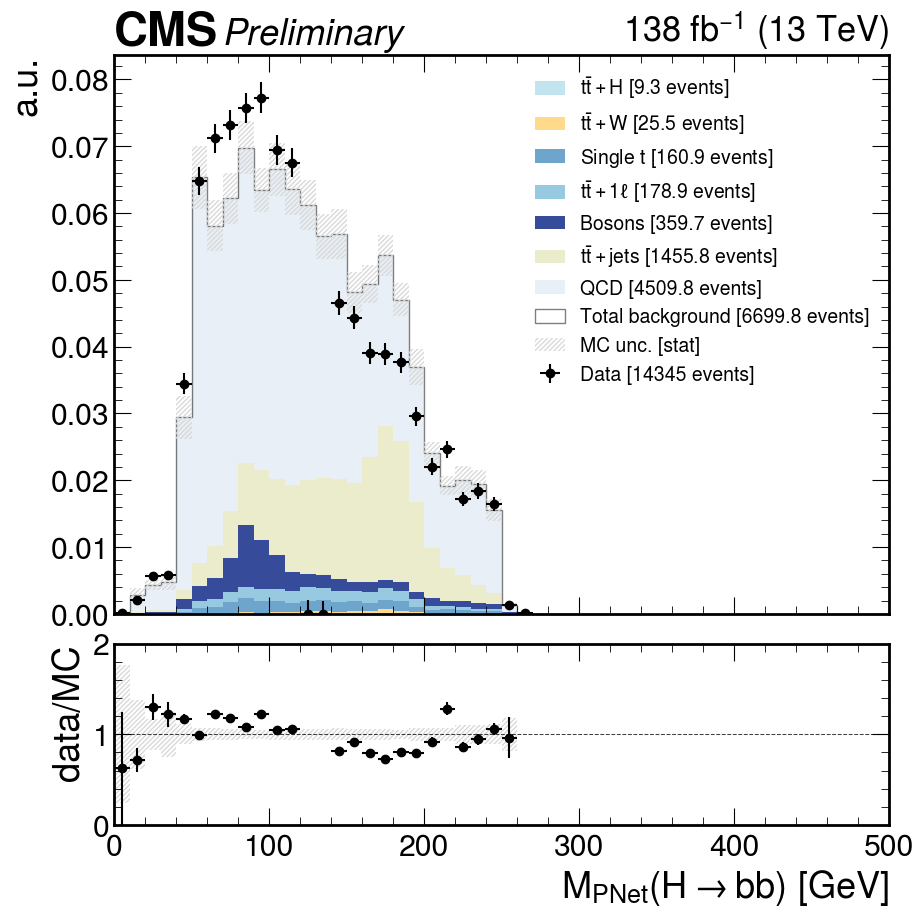

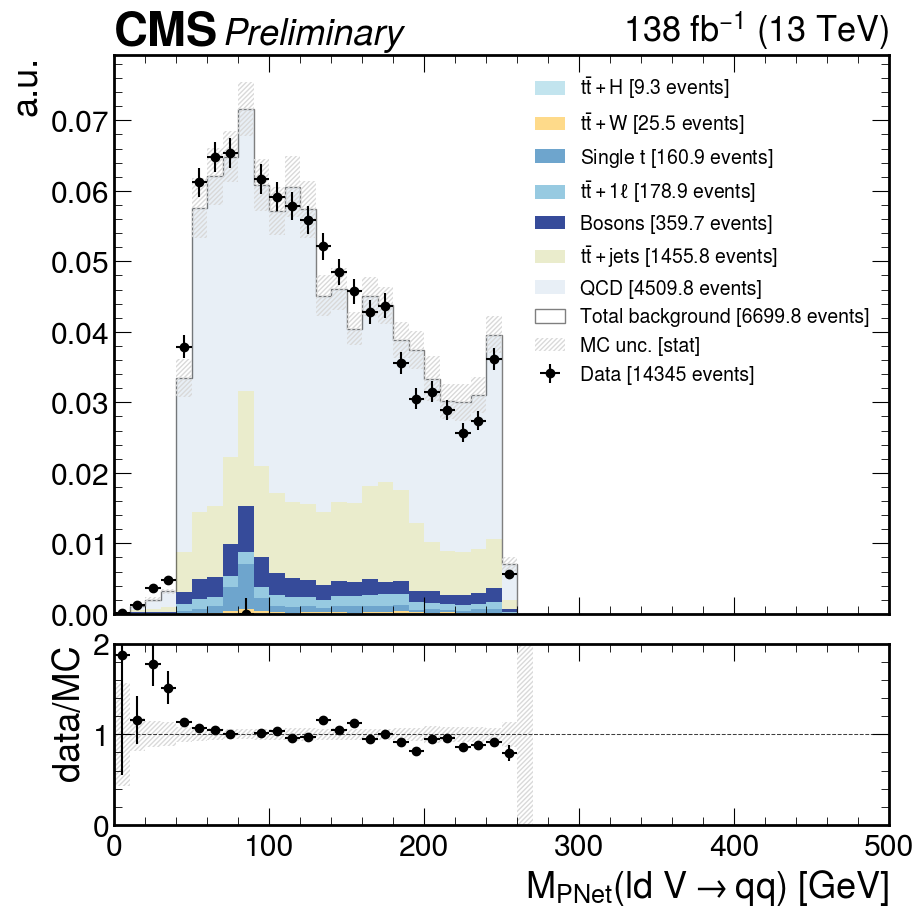

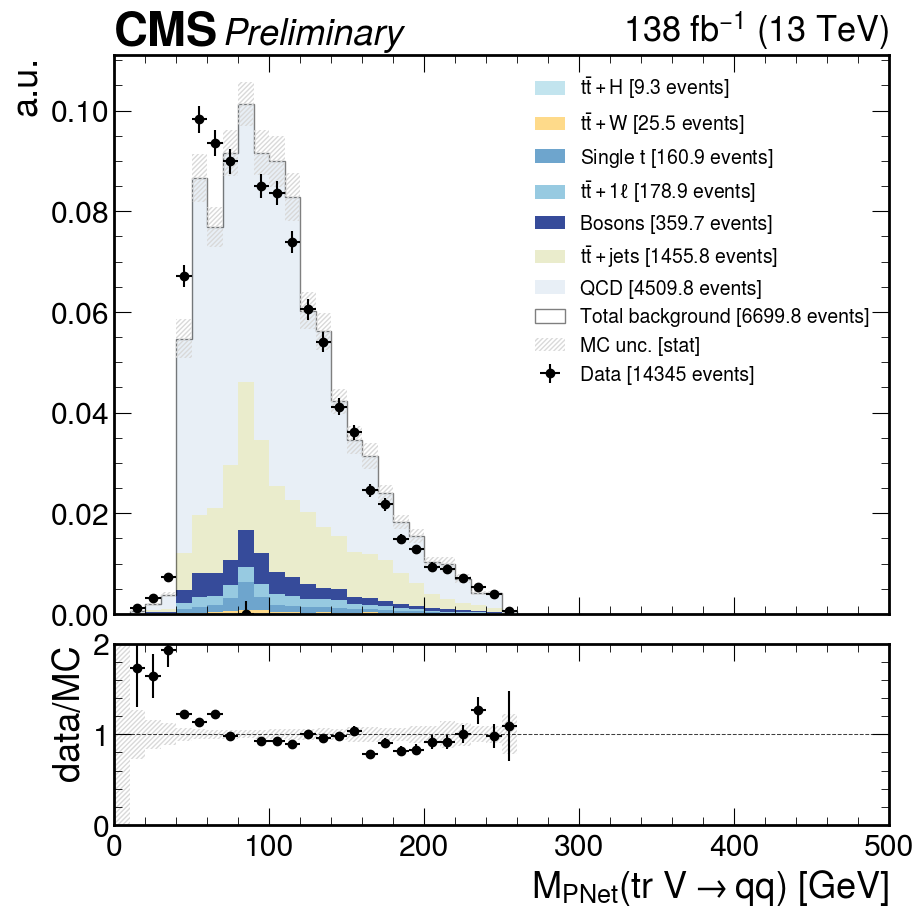

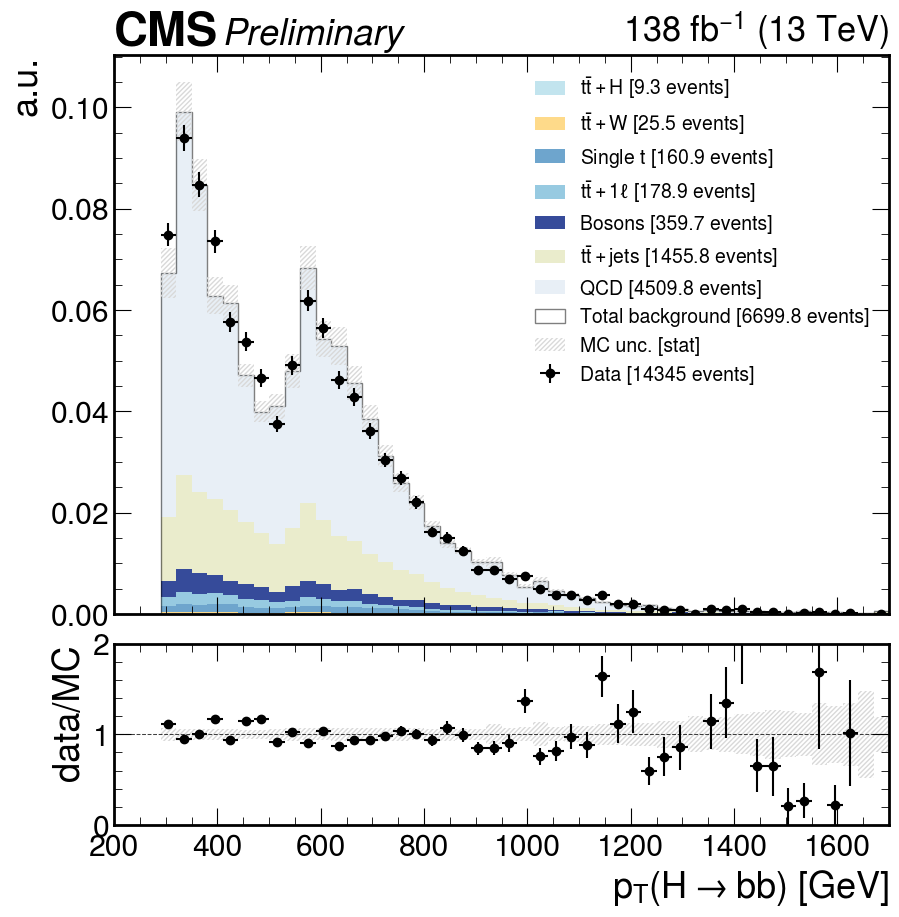

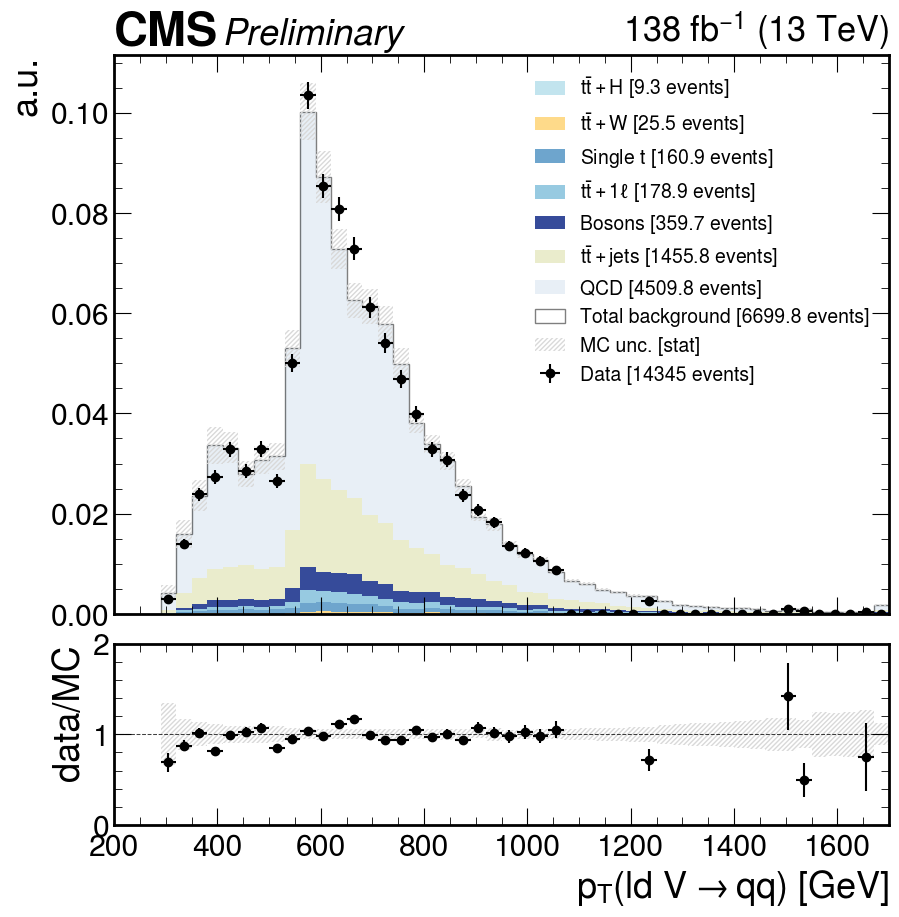

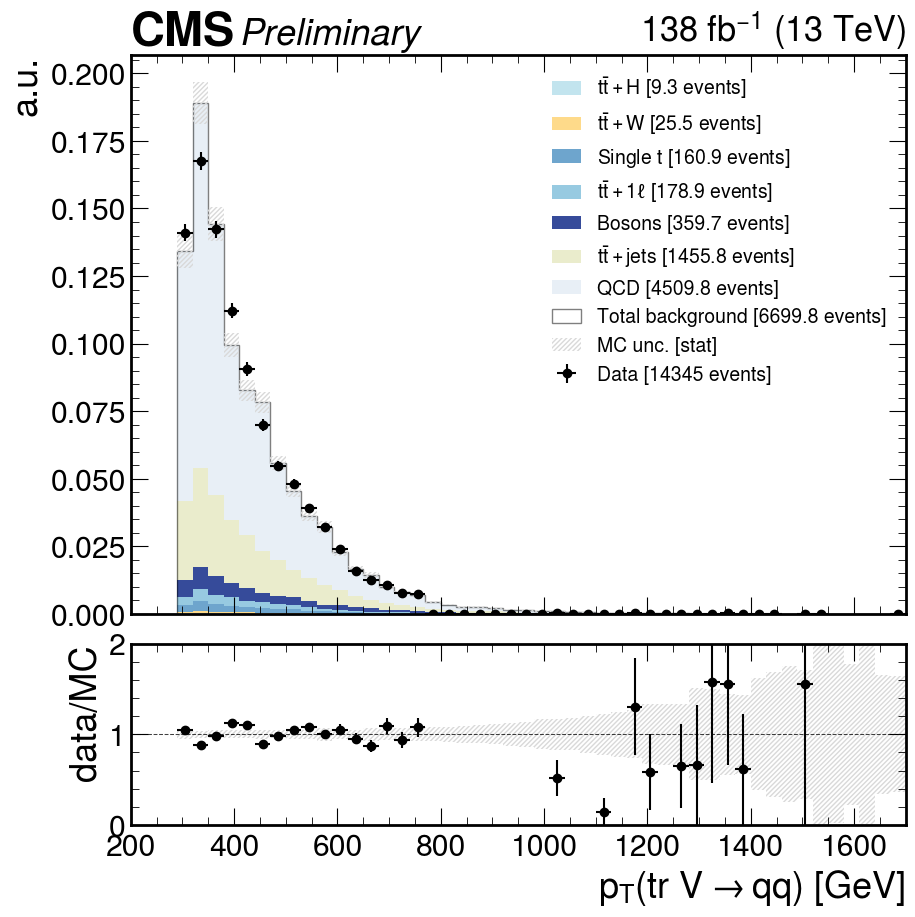

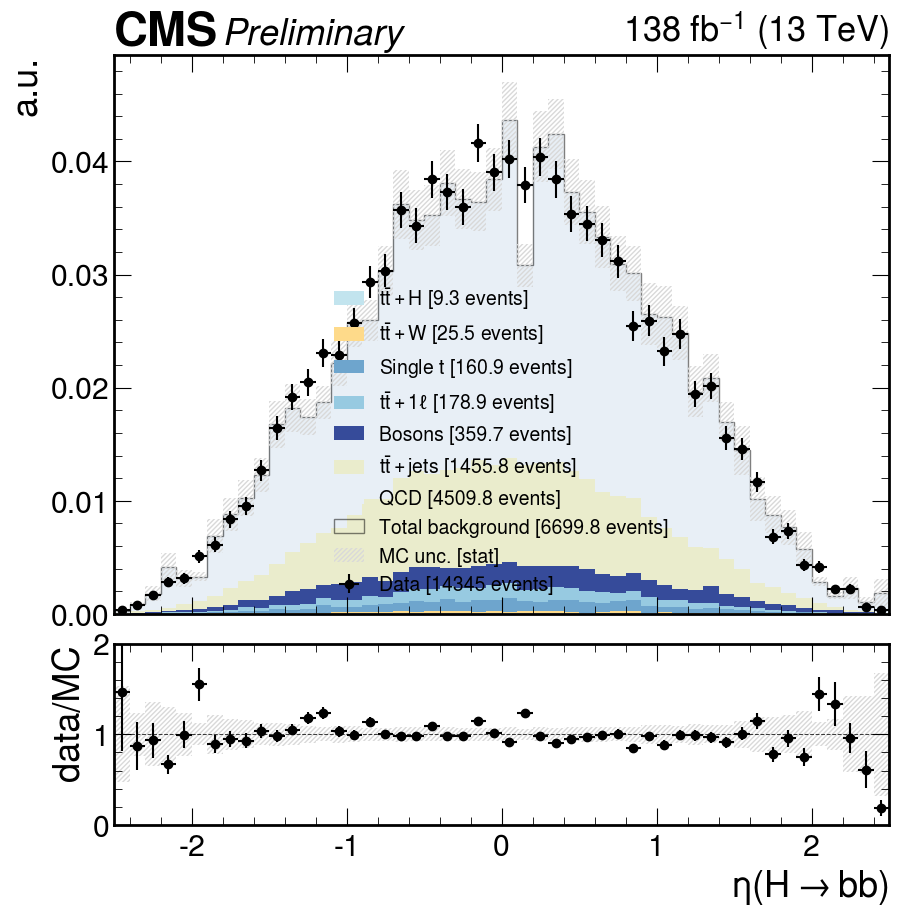

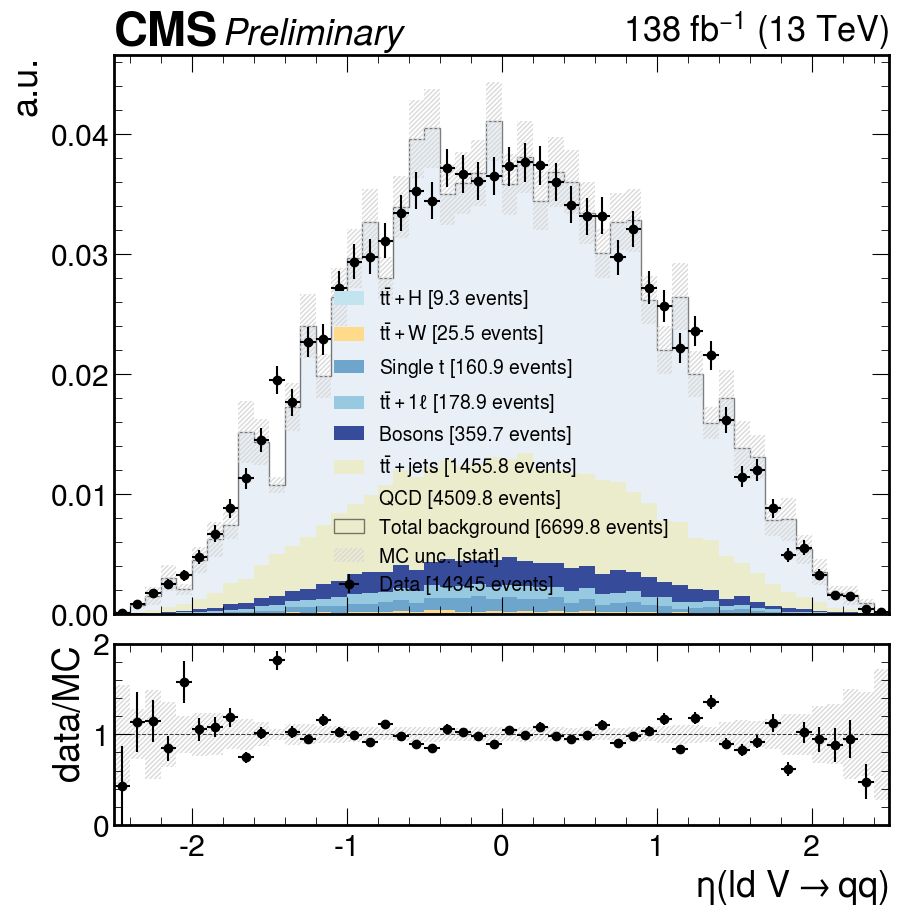

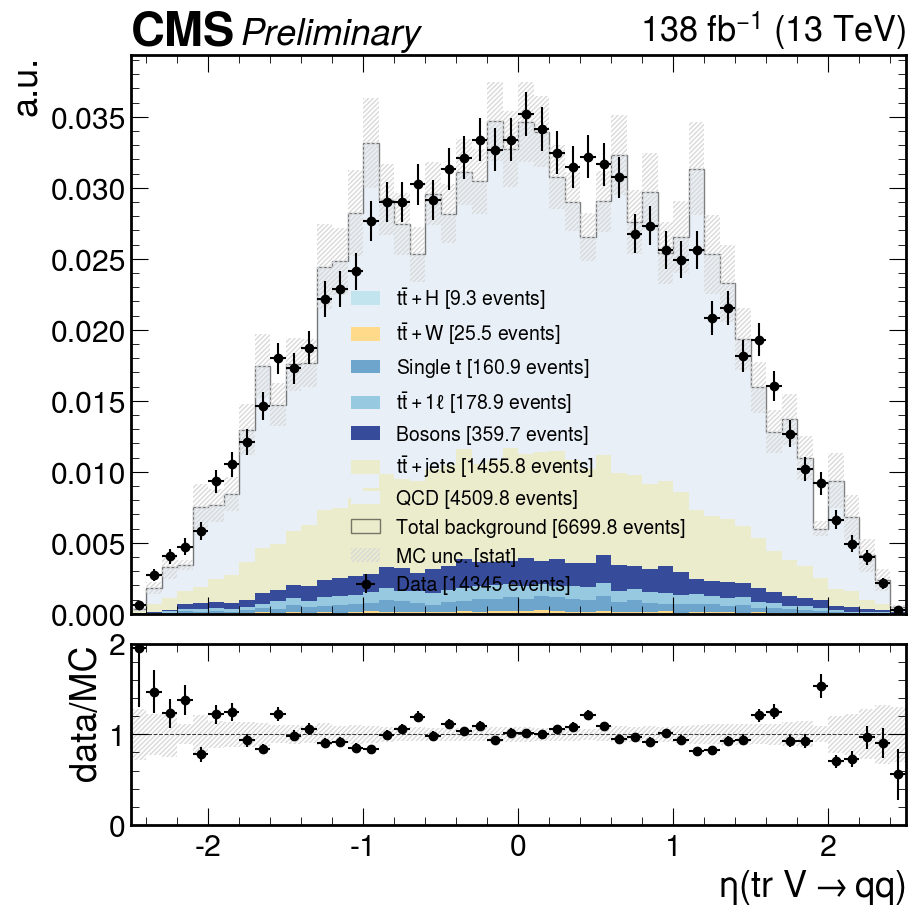

In [8]:
nbins = 50

plot_many(
    [
        # Event-level variables
        ("ST", np.linspace(1000, 3000, nbins+1), r"$S_T$ [GeV]"),
        ("HT", np.linspace(0, 1500, nbins+1), r"$H_{T, AK4}$ [GeV]"),
        ("HT_fat", np.linspace(1000, 3000, nbins+1), r"$H_{T, AK8}$ [GeV]"),
        ("MET", np.linspace(0, 500, nbins+1), "MET [GeV]"),
        ("n_jets", np.linspace(0, 10, 11), r"$N_{AK4}$"),
        ("n_fatjets", np.linspace(0, 10, 11), r"$N_{AK8}$"),
        # VBS variables
        ("M_jj", np.linspace(0, 2000, nbins+1), r"$M_{jj}$ [GeV]"),
        ("abs_deta_jj", np.linspace(0, 10, nbins+1), r"$|\Delta\eta_{jj}|$"),
        ("ld_vbsjet_pt", np.linspace(0, 500, nbins+1), r"$p_T($ld VBS$)$ [GeV]"),
        ("tr_vbsjet_pt", np.linspace(0, 500, nbins+1), r"$p_T($tr VBS$)$ [GeV]"),
        ("ld_vbsjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta($ld VBS$)$"),
        ("tr_vbsjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta($tr VBS$)$"),
        # VVH variables
        ("M_VVH", np.linspace(1000, 5000, nbins+1), r"$M_{VVH}$ [GeV]"),
        ("dphi_VV", np.linspace(-4, 4, nbins+1), r"$\Delta\phi($ld $V\rightarrow qq, $tr $V \rightarrow qq)$"),
        ("dphi_ldVH", np.linspace(-4, 4, nbins+1), r"$\Delta\phi(H\rightarrow b\bar{b}, $ld $V \rightarrow qq)$"),
        ("dphi_trVH", np.linspace(-4, 4, nbins+1), r"$\Delta\phi(H\rightarrow b\bar{b}, $tr $V \rightarrow qq)$"),
        # Fat jet MSD
        ("hbbfatjet_msoftdrop", np.linspace(0, 500, nbins+1), r"$M_{SD}(H\rightarrow bb)$ [GeV]"),
        ("ld_vqqfatjet_msoftdrop", np.linspace(0, 500, nbins+1), r"$M_{SD}($ld $V\rightarrow qq)$ [GeV]"),
        ("tr_vqqfatjet_msoftdrop", np.linspace(0, 500, nbins+1), r"$M_{SD}($tr $V\rightarrow qq)$ [GeV]"),
        # Fat jet ParticleNet mass
        ("hbbfatjet_mass", np.linspace(0, 500, nbins+1), r"$M_{PNet}(H\rightarrow bb)$ [GeV]"),
        ("ld_vqqfatjet_mass", np.linspace(0, 500, nbins+1), r"$M_{PNet}($ld $V\rightarrow qq)$ [GeV]"),
        ("tr_vqqfatjet_mass", np.linspace(0, 500, nbins+1), r"$M_{PNet}($tr $V\rightarrow qq)$ [GeV]"),
        # Fat jet pt
        ("hbbfatjet_pt", np.linspace(200, 1700, nbins+1), r"$p_T(H\rightarrow bb)$ [GeV]"),
        ("ld_vqqfatjet_pt", np.linspace(200, 1700, nbins+1), r"$p_T($ld $V\rightarrow qq)$ [GeV]"),
        ("tr_vqqfatjet_pt", np.linspace(200, 1700, nbins+1), r"$p_T($tr $V\rightarrow qq)$ [GeV]"),
        # Fat jet eta
        ("hbbfatjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta(H\rightarrow bb)$"),
        ("ld_vqqfatjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta($ld $V\rightarrow qq)$"),
        ("tr_vqqfatjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta($tr $V\rightarrow qq)$"),
    ],
    sel="presel",
    norm=True,
#     sig_scale=0
)